# Further Column Derivations, Analysis, and Visualizations

## 1. Customer spending by region
## 2. Exclusion flag for low activity customers
## 3. Create customer profiles based on:
###       a. age
###       b. income
###       c. products purchased
###       d. number of dependants
## 4. Visualization for distribution of profile variables in 3
## 5. Compare profiles by region and department
## 6. Visualizations & crosstabs

In [2]:
#import libraries
import pandas as pd
import numpy as np
import os

In [3]:
#create file path string
path = r'C:\Users\krist\08.2023_InstacartBasketAnalysis'

In [4]:
#import latest fully combined dataset with customer information and check import
df_ords_prods_all = pd.read_pickle(os.path.join(path, '02.Data', 'Prepared_Data', 'orders_products_all.pkl'))
df_ords_prods_all.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_last_order,product_id,add_to_cart_order,reordered,product_name,...,Spending_flag,median_days_since_last_order,frequency_flag,Gender,State,Age,date_joined,num_dependants,fam_status,income
0,2539329,1,1,2,8,11.0,196,1,0,Soda,...,Low spender,20.0,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423
1,2398795,1,2,3,7,15.0,196,1,1,Soda,...,Low spender,20.0,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423
2,473747,1,3,3,12,21.0,196,1,1,Soda,...,Low spender,20.0,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423
3,2254736,1,4,4,7,29.0,196,1,1,Soda,...,Low spender,20.0,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423
4,431534,1,5,4,15,28.0,196,1,1,Soda,...,Low spender,20.0,Regular customer,Female,Alabama,31,2/17/2019,3,married,40423


In [4]:
#check shape 
df_ords_prods_all.shape

(32404859, 30)

### shape is same as exported file. import successful

## 1. Create new column for region

In [5]:
#create new column for region using state. Regions are Northeast, Midwest, South, West
#create region lists
Northeast = ['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island',
             'Connecticut','New York','Pennsylvania','New Jersey']
Midwest = ['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota',
           'South Dakota','Nebraska','Kansas','Minnesota','Iowa','Missouri']
South = ['Delaware','Maryland','District of Columbia','Virginia','West Virginia',
         'North Carolina','South Carolina','Georgia','Florida','Kentucky',
         'Tennessee','Mississippi','Alabama','Oklahoma','Texas','Arkansas','Louisiana']
West = ['Idaho','Montana','Wyoming','Nevada','Utah','Colorado','Arizona','New Mexico',
        'Alaska','Washington','Oregon','California','Hawaii']

In [6]:
# use lamba function to create new regions column 
df_ords_prods_all['Region'] = df_ords_prods_all['State'].apply(lambda x: 'Northeast' if x in Northeast else
                                                              'Midwest' if x in Midwest else
                                                              'South' if x in South else
                                                              'West' if x in West else np.nan)

In [7]:
#check region column
df_ords_prods_all['Region'].value_counts()

South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: Region, dtype: int64

In [8]:
#check region column
df_ords_prods_all['Region'].head(20)

0     South
1     South
2     South
3     South
4     South
5     South
6     South
7     South
8     South
9     South
10    South
11    South
12    South
13    South
14    South
15    South
16    South
17    South
18    South
19    South
Name: Region, dtype: object

In [9]:
#explore spending habits by region
reg_spend_xtab = pd.crosstab(df_ords_prods_all['Region'], df_ords_prods_all['Spending_flag'], dropna = False)
reg_spend_xtab

Spending_flag,High spender,Low spender
Region,,
Midwest,155975,7441350
Northeast,108225,5614511
South,209691,10582194
West,160354,8132559


### South appears to have greatest number of high spenders (209,691) but it also has the greatest number of states. Need to create % of total columns 

In [10]:
#create percent high column for spending by region crosstab
reg_spend_xtab['Percent_high'] = (reg_spend_xtab['High spender'] / (reg_spend_xtab['High spender']+reg_spend_xtab['Low spender']))*100
reg_spend_xtab

Spending_flag,High spender,Low spender,Percent_high
Region,,,
Midwest,155975,7441350,2.053025
Northeast,108225,5614511,1.891141
South,209691,10582194,1.943043
West,160354,8132559,1.933627


In [11]:
#create percent low column for spending by region crosstab
reg_spend_xtab['Percent_low'] = (reg_spend_xtab['Low spender'] / (reg_spend_xtab['High spender']+reg_spend_xtab['Low spender']))*100
reg_spend_xtab

Spending_flag,High spender,Low spender,Percent_high,Percent_low
Region,,,,
Midwest,155975,7441350,2.053025,97.946975
Northeast,108225,5614511,1.891141,98.108859
South,209691,10582194,1.943043,98.056957
West,160354,8132559,1.933627,98.066373


In [12]:
reg_spend_xtab.to_clipboard()

### Midwest has the highest percentage of high spenders followed by South, West, then Northeast is last

## 2. Create a low activity exclusion flag

### low acvitity defined as less than 5 orders

In [13]:
#explore max, min, mean for order_number to determine remaining activity labels
df_ords_prods_all['order_number'].describe()

count    3.240486e+07
mean     1.714230e+01
std      1.753532e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.100000e+01
75%      2.400000e+01
max      9.900000e+01
Name: order_number, dtype: float64

### low activity less than 5 orders
### regular activity 5 to 7 orders
### high activity more than 7 orders

In [14]:
#use max_order column to create activity flag
df_ords_prods_all.loc[df_ords_prods_all['max_order'] <5,
                      'activity_flag'] = 'low_activity'

In [15]:
df_ords_prods_all.loc[(df_ords_prods_all['max_order'] <=7) & 
                      (df_ords_prods_all['max_order'] >=5),
                      ['activity_flag']] = 'regular_activity'

In [16]:
df_ords_prods_all.loc[df_ords_prods_all['max_order'] >7,
                      ['activity_flag']] = 'high_activity'

In [17]:
#check for new column
df_ords_prods_all.columns

Index(['order_id', 'user_id', 'order_number', 'order_day_of_week',
       'order_hour_of_day', 'days_since_last_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest_day',
       'busiest_days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'users_avg_product_price', 'Spending_flag',
       'median_days_since_last_order', 'frequency_flag', 'Gender', 'State',
       'Age', 'date_joined', 'num_dependants', 'fam_status', 'income',
       'Region', 'activity_flag'],
      dtype='object')

In [18]:
#check new column frequency
df_ords_prods_all['activity_flag'].value_counts()

high_activity       28556049
regular_activity     2408515
low_activity         1440295
Name: activity_flag, dtype: int64

### high_activity     28,556,049
### regular_activity    2,408,515
### low_activity    1,440,295

In [19]:
#create subset with only low activity users
low_activity_users = df_ords_prods_all[df_ords_prods_all['activity_flag'] == 'low_activity']

In [20]:
#check subset shape
low_activity_users.shape

(1440295, 32)

### rows of subset match count from activity_flag column 1,440,295

In [21]:
#export low activity subset
low_activity_users.to_pickle(os.path.join(path, 
                                          '02.Data', 
                                          'Prepared_Data', 
                                          'ords_prods_low_activity_subset.pkl'))

In [22]:
#create new dataframe with low_activity users excluded
df_ords_prods_no_low = df_ords_prods_all.loc[df_ords_prods_all['activity_flag'].isin(['regular_activity',
                                                                                      'high_activity'])]

In [23]:
#check shape should have 30,964,564 rows
df_ords_prods_no_low.shape

(30964564, 32)

In [24]:
#check counts for activity flag, shouldn't have any low activity
df_ords_prods_no_low['activity_flag'].value_counts()

high_activity       28556049
regular_activity     2408515
Name: activity_flag, dtype: int64

### excluded low activity users. new row count with low activity users excluded is 30,964,564

## 3. Create customer profiles

In [25]:
#older adults num_dependants = 0, age >=65, departments 1, 3, 13, 15
df_ords_prods_no_low.loc[(df_ords_prods_no_low['num_dependants'] == 0) & 
                         (df_ords_prods_no_low['Age'] >= 65) &
                         (df_ords_prods_no_low['department_id'].isin([1, 3, 13, 15])),
                         'Demographic_profile'] = 'Adults 65+'

C:\Users\krist\AppData\Local\Temp\ipykernel_20840\1108761001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ords_prods_no_low.loc[(df_ords_prods_no_low['num_dependants'] == 0) &


In [26]:
#check for labesl in new column
df_ords_prods_no_low['Demographic_profile'].value_counts()

Adults 65+    394000
Name: Demographic_profile, dtype: int64

In [27]:
#create a label for dual income high earners: 
#num_dependants = 0, income = >125,000, fam_status = married, departments 4,5,7,10,19
df_ords_prods_no_low.loc[(df_ords_prods_no_low['num_dependants'] == 0) &
                        (df_ords_prods_no_low['fam_status'] == 'married') &
                         (df_ords_prods_no_low['income'] >= 150000) &
                         (df_ords_prods_no_low['department_id'].isin([4,5,7,10,19])),
                         'Demographic_profile'] = 'Dual inc high earners'

In [28]:
#check for labesl in new column
df_ords_prods_no_low['Demographic_profile'].value_counts()

Adults 65+    394000
Name: Demographic_profile, dtype: int64

### there appear to be no customers who are married without children

In [29]:
#check that there aren't any married customers without children
demo_xtab = pd.crosstab(df_ords_prods_no_low['fam_status'], 
                        df_ords_prods_no_low['num_dependants'], 
                        dropna = False)
demo_xtab

num_dependants,0,1,2,3
fam_status,,,,
divorced/widowed,2645271,0,0,0
living with parents and siblings,0,508045,484658,488469
married,0,7211061,7248603,7284047
single,5094410,0,0,0


In [30]:
#create a label for young singles (avg starting salary assumed 55k): 
#num_dependants = 0, income = <60,000, fam_status = single, age <=30
df_ords_prods_no_low.loc[(df_ords_prods_no_low['num_dependants'] == 0) &
                         (df_ords_prods_no_low['income'] <60000) &
                        (df_ords_prods_no_low['fam_status'] == 'single') &
                         (df_ords_prods_no_low['department_id'].isin([1,4,5,7,14,19])) &
                         (df_ords_prods_no_low['Age'].isin([22,23,24,25,26,27,28,29,30,31,32,33,34,35])),
                         'Demographic_profile'] = 'Young single professionals'

In [31]:
#check for labesl in new column
df_ords_prods_no_low['Demographic_profile'].value_counts()

Adults 65+                    394000
Young single professionals    318536
Name: Demographic_profile, dtype: int64

In [32]:
#create a label for young adult at home 
#fam_status = living with parents and siblings, age <=25
df_ords_prods_no_low.loc[(df_ords_prods_no_low['fam_status'] == 'living with parents and siblings') &
                         (df_ords_prods_no_low['department_id'].isin([9,13,19])) &
                         (df_ords_prods_no_low['Age'] <= 25),
                         'Demographic_profile'] = 'Young adult at home'

In [33]:
#check for labesl in new column
df_ords_prods_no_low['Demographic_profile'].value_counts()

Adults 65+                    394000
Young single professionals    318536
Young adult at home           256697
Name: Demographic_profile, dtype: int64

In [34]:
#create a label for married with babies: 
#num_dependants > 0, fam_status = married
df_ords_prods_no_low.loc[(df_ords_prods_no_low['num_dependants'] > 0) &
                        (df_ords_prods_no_low['fam_status'] == 'married') &
                         (df_ords_prods_no_low['department_id'].isin([1,4,11,16,17,18])),
                         'Demographic_profile'] = 'Married with babies'

In [35]:
#check for labesl in new column
df_ords_prods_no_low['Demographic_profile'].value_counts()

Married with babies           12576015
Adults 65+                      394000
Young single professionals      318536
Young adult at home             256697
Name: Demographic_profile, dtype: int64

In [36]:
#ensure each user_id only has one profile label
df_ords_prods_no_low['Demographic_profile'] = df_ords_prods_no_low.groupby('user_id')['Demographic_profile'].transform('first')

C:\Users\krist\AppData\Local\Temp\ipykernel_20840\2637209953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ords_prods_no_low['Demographic_profile'] = df_ords_prods_no_low.groupby('user_id')['Demographic_profile'].transform('first')


In [37]:
#check overall frequency of demographic_profile
df_ords_prods_no_low['Demographic_profile'].value_counts()

Married with babies           21728155
Adults 65+                     2007066
Young adult at home            1473472
Young single professionals      552506
Name: Demographic_profile, dtype: int64

In [38]:
#check distribution of customer profiles
#customer count is 162,631
df_ords_prods_no_low.groupby('Demographic_profile')['user_id'].nunique()

Demographic_profile
Adults 65+                     10311
Married with babies           113644
Young adult at home             7386
Young single professionals      3316
Name: user_id, dtype: int64

### married with babies make up majority of customer base 69.9%
### the next largest demographic group is adults 65+ 6.3%
### 27,974 or 17.2% are currently uncategorized

In [39]:
#check user ids have same category
df_ords_prods_no_low[['user_id','Demographic_profile']].tail(30)

,user_id,Demographic_profile
32404822,120516,None
32404823,120516,None
32404824,120516,None
32404825,120516,None
32404829,106143,Young single professionals
32404830,106143,Young single professionals
32404831,106143,Young single professionals
32404832,106143,Young single professionals
32404833,106143,Young single professionals
32404834,106143,Young single professionals


## 4. Create visualizations for customer profiles

### import libraries for visualizations

In [40]:
#import seaborn, matplotlib, and scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

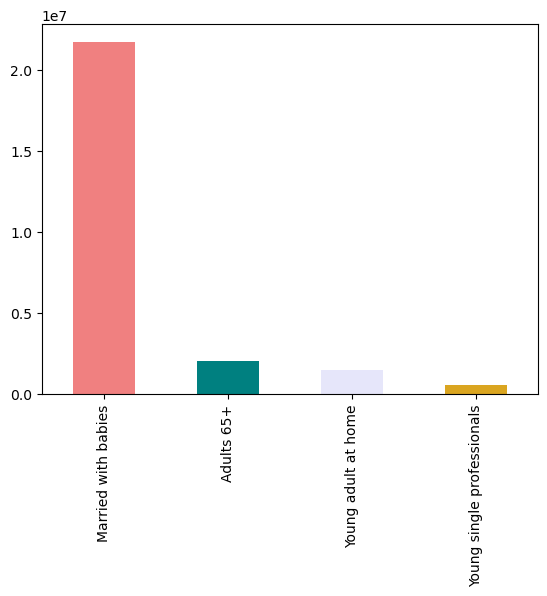

In [41]:
demographic_profile_bar = df_ords_prods_no_low['Demographic_profile'].value_counts().plot.bar(color = 
                                                                    ['lightcoral','teal', 'lavender', 'goldenrod'])

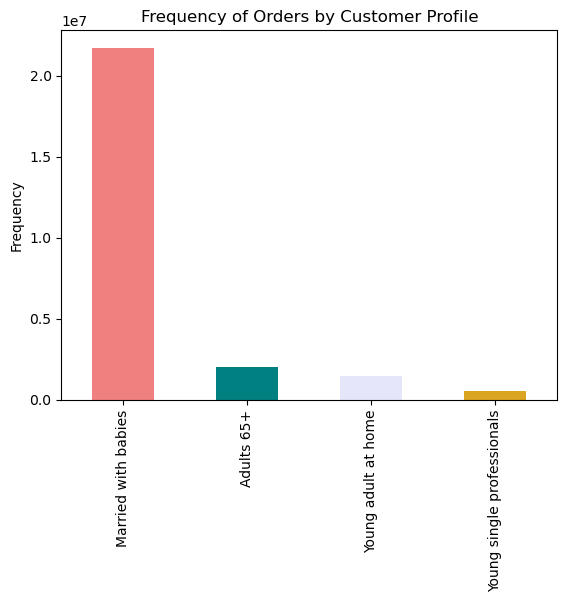

In [42]:
demographic_profile_bar.set_ylabel('Frequency')
demographic_profile_bar.set_title('Frequency of Orders by Customer Profile')
demographic_profile_bar.figure

In [43]:
#export barchart
demographic_profile_bar.figure.savefig(os.path.join(path, 
                                                 '04.Analysis', 
                                                 'Visualizations', 
                                                'demo_profile_frequency_bar.png'))

### Aggregate max mean min for customer profiles based on frequency and expenditure

In [44]:
agg_demo_prices_tbl = df_ords_prods_no_low.groupby('Demographic_profile').agg({'prices': ['mean', 'min', 'max'],
                                                         'days_since_last_order': ['mean', 'min', 'max']})

### adults 65+ pay highest average prices but separation from between highest and lowest is less than 0.5
### young single professionals go the longest on average before ordering again 11 days 

In [45]:
agg_demo_prices_tbl.to_clipboard()

## 5. Compare customer profiles based on region and department

In [46]:
#create crosstab for demographic profile and region
region_cust_prof_xtab = pd.crosstab(df_ords_prods_no_low['Demographic_profile'], 
                                    df_ords_prods_no_low['Region'],
                                    dropna = False)
region_cust_prof_xtab

Region,Midwest,Northeast,South,West
Demographic_profile,,,,
Adults 65+,467306,376338,651803,511619
Married with babies,5083382,3851067,7219172,5574534
Young adult at home,349804,255403,503041,365224
Young single professionals,117148,100971,187453,146934


In [47]:
#create crosstab for demographic profile and department
dept_cust_prof_xtab = pd.crosstab(df_ords_prods_no_low['department_id'], 
                                  df_ords_prods_no_low['Demographic_profile'],
                                  dropna = False)
dept_cust_prof_xtab

Demographic_profile,Adults 65+,Married with babies,Young adult at home,Young single professionals
department_id,,,,
1,141104,1489390,102599,35754
2,2139,23853,1810,674
3,72418,785320,53425,19517
4,590869,6373293,427330,152676
5,8734,98070,8122,2341
6,16479,179100,12379,4248
7,165271,1799754,118001,51028
8,6698,64111,5315,1922
9,53219,578214,39542,13239


### top two departments for all groups are produce and dairy and eggs
### bottom two are bulk and other for all groups

## 6. Create more visualizations

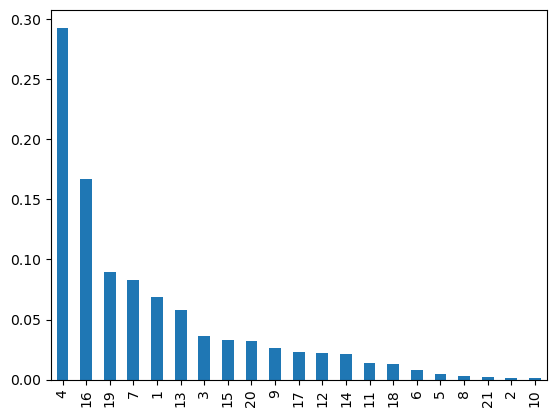

In [48]:
#create bar chart by department
department_bar = df_ords_prods_no_low['department_id'].value_counts(normalize = True).plot.bar()

In [49]:
labels = ['Produce', 'Dairy eggs', 'Snacks', 'Beverages', 
          'Frozen', 'Pantry', 'Bakery', 'Canned goods', 
          'Deli', 'Dry goods pasta', 'Household', 'Meat Seafood', 
          'Breakfast', 'Personal Care', 'Babies','International', 
          'Alcohol', 'Pets', 'Missing', 'Other', 'Bulk']

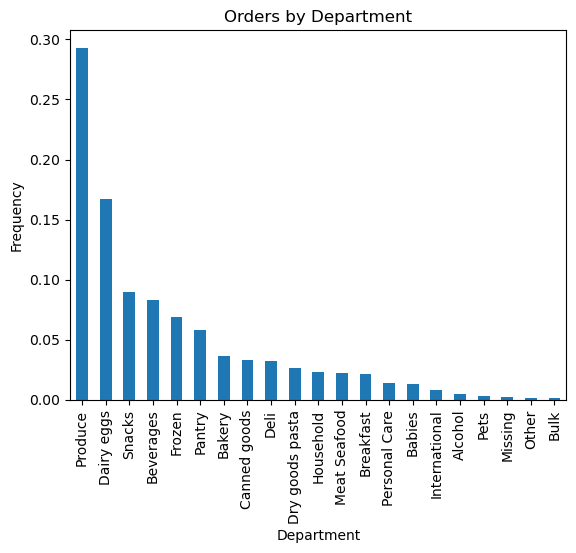

In [50]:
department_bar.set_xlabel('Department')
department_bar.set_xticklabels(labels)
department_bar.set_ylabel('Frequency')
department_bar.set_title('Orders by Department')
department_bar.figure

In [51]:
#export
department_bar.figure.savefig(os.path.join(path, 
                                                 '04.Analysis', 
                                                 'Visualizations', 
                                                 'ords_by_dept.png'))

In [52]:
#create crosstab for loyalty and department
dept_loyal_xtab = pd.crosstab(df_ords_prods_no_low['department_id'], 
                                  df_ords_prods_no_low['loyalty_flag'],
                                  dropna = False)
dept_loyal_xtab

loyalty_flag,Loyal customer,New customer,Regular customer
department_id,,,
1,609460,372271,1140000
2,10715,5839,17857
3,379873,172104,568851
4,3147376,1336604,4595293
5,38723,28629,77275
6,78394,43841,133756
7,855017,396649,1320235
8,25469,15880,51711
9,242580,144836,434720


In [53]:
dept_loyal_xtab.to_clipboard()

### no difference between top and bottom departments by loyalty

In [54]:
#create crosstab for demographic and spending
demo_spend_xtab = pd.crosstab(df_ords_prods_no_low['Demographic_profile'], 
                                  df_ords_prods_no_low['Spending_flag'],
                                  dropna = False)
demo_spend_xtab

Spending_flag,High spender,Low spender
Demographic_profile,,
Adults 65+,41350,1965716
Married with babies,428022,21300133
Young adult at home,27410,1446062
Young single professionals,1342,551164


In [55]:
#create crosstab for demographic and price range
demo_price_xtab = pd.crosstab(df_ords_prods_no_low['Demographic_profile'], 
                                  df_ords_prods_no_low['price_range_loc'],
                                  dropna = False)
demo_price_xtab

price_range_loc,High-range product,Low-range product,Mid-range product
Demographic_profile,,,
Adults 65+,26359,625862,1354845
Married with babies,281446,6787416,14659293
Young adult at home,18916,459518,995038
Young single professionals,5313,190454,356739


In [56]:
#create crosstab for region and spending
region_spend_xtab = pd.crosstab(df_ords_prods_no_low['Region'], 
                                  df_ords_prods_no_low['Spending_flag'],
                                  dropna = False)
region_spend_xtab

Spending_flag,High spender,Low spender
Region,,
Midwest,148678,7112835
Northeast,103120,5361565
South,199339,10111800
West,152288,7774939


In [57]:
#create crosstab for region and price range
region_price_xtab = pd.crosstab(df_ords_prods_no_low['Region'], 
                                  df_ords_prods_no_low['price_range_loc'],
                                  dropna = False)
region_price_xtab

price_range_loc,High-range product,Low-range product,Mid-range product
Region,,,
Midwest,93280,2267085,4901148
Northeast,69732,1712360,3682593
South,132661,3217500,6960978
West,102280,2477895,5347052


In [58]:
#create crosstab for region and department_id
region_dept_xtab = pd.crosstab(df_ords_prods_no_low['department_id'], 
                                  df_ords_prods_no_low['Region'],
                                  dropna = False)
region_dept_xtab

Region,Midwest,Northeast,South,West
department_id,,,,
1,498225,370436,709906,543164
2,7983,6268,11579,8581
3,261753,199300,371620,288155
4,2134115,1593004,3027476,2324678
5,34043,25017,48813,36754
6,60666,44678,84649,65998
7,598979,462929,859419,650574
8,21358,17734,29909,24059
9,193463,143817,272813,212043


In [59]:
#check if loyalty impacts item prices or days since last order
agg_loyal_prices_tbl = df_ords_prods_no_low.groupby('loyalty_flag').agg({'prices': ['mean', 'min', 'max'],
                                                         'days_since_last_order': ['mean', 'min', 'max']})

In [60]:
#check if loyalty impacts item prices or days since last order
agg_loyal_prices_tbl

prices            days_since_last_order           
                      mean  min   max                  mean  min   max
loyalty_flag                                                          
Loyal customer    7.773575  1.0  25.0              6.117916  0.0  30.0
New customer      7.801665  1.0  25.0             16.668049  0.0  30.0
Regular customer  7.798262  1.0  25.0             12.097288  0.0  30.0

In [61]:
agg_loyal_prices_tbl.to_clipboard()

## Export final data set

In [62]:
#export dataset 
df_ords_prods_no_low.to_pickle(os.path.join(path, 
                                            '02.Data', 
                                            'Prepared_Data', 
                                            'orders_products_final.pkl'))